In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time

In [8]:
def Sphere(x):
    return np.sum(np.square(x), axis=2)

def Rastrigin(x):
    d = x.shape[2]
    return 10*d + np.sum(np.square(x) - 10*(np.cos(2*np.pi*x)), axis=2)

def Ackley(x):
    d = x.shape[2]
    return 20 - 20*np.exp(-0.2*np.sqrt((1/d)*np.sum(np.square(x), axis=2))) + np.e - np.exp((1/d)*np.sum((np.cos(2*np.pi*x)), axis=2))

In [9]:
def contour_plot(domain, level, objective_function, given_X):
    
    d_min = np.min(domain)
    d_max = np.max(domain) 
    domain = np.arange(d_min, d_max, 0.1)
   
    x_1, x_2 = np.meshgrid(domain, domain)
    
    X = np.dstack((x_1, x_2))
    y = objective_function(X)
    
    fig = plt.figure(figsize=(5, 5))
    
    ax_1 = fig.add_subplot(1, 1, 1)

    ax_1.set_title('Contour of ' + objective_function.__name__+', CMA')
    ax_1.contour(x_1, x_2, y, cmap='turbo', levels=level)
    
    in_domain = (given_X > d_min + 0.1) * (given_X < d_max - 0.1)
    given_X = np.delete(given_X, np.where(in_domain==False)[0], axis=0)
    
    if given_X.shape[2] == 2:
        plt.plot(given_X[:, :, 0], given_X[:, :, 1], 'r+')
    if given_X.shape[2] == 3:
        ax_1.scatter(given_X[:, :, 0] , given_X[:, :, 1] , given_X[:, :, 2],  c='r')
#     plt.savefig('Contour of '+ objective_function.__name__ + ', CMA'+'.png')
    plt.show() 

In [10]:
def sigma_plot(sigma, generation, d):
     
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('Step-Size of '+ objective_function.__name__+' ,d='+str(d))
    
    plt.xlabel('generation')
    plt.ylabel('sigma')
        
    plt.plot(range(generation), sigma, 'b--.')
#     plt.savefig('Step-Size of '+ objective_function.__name__ +' ,d='+str(d)+ '.png')
    plt.show() 

In [25]:
def cma(domain, objective_function, d=2):

    X = []
    Sigma = []
    resultX, resultY = 0, 0
    
    # objective function domain
    d_min = np.min(domain)
    d_max = np.max(domain)
    
    # initialize population
    m = np.random.uniform(low=d_min, high=d_max, size=(d, 1))
    sigma = 0.3*(d_max-d_min)
    
    # termination parameters
    stop_fitness = 1e-10
    stop_generation = (1e3*d**2)*10
    
    # lambda & mu
    LAMBDA = int(4+np.floor(3*np.log(d)))
    MU = int(LAMBDA/2)
    
    # weights
    w = np.log(MU+1/2)-np.log(range(1, MU+1)).reshape(MU, 1)
    w = w / np.sum(w)

    # step size control parameters 
    mueff = 1 / np.sum(w**2)
    cs = (mueff+2) / (d+mueff+5)
    ds = 1 + 2*np.maximum(0, np.sqrt((mueff-1)/(d+1)) - 1) + cs
    
    # covariance matrix parameters
    alpha = 2
    cc = (4+mueff/d) / (d+4+2*mueff/d)
    c1 = alpha / ((d+1.3)**2+mueff)
    cmu = np.minimum(1-c1, alpha*((mueff-2+1/mueff) / ((d+2)**2+alpha*mueff/2)))
    
    # evolution path
    ps = np.zeros((d, 1))
    pc = np.zeros((d, 1))
    
    # matrices
    B = np.eye(d)
    D = np.eye(d)
    C = B@D@(B@D).T
    update_matrix = 0
    
    # expectation of ||N(0, I)||
    E = d**0.5*(1-1/(4*d)+1/(21*d**2))
    
    # loop
    population_size = 0
    while population_size < stop_generation:
        # generate offspring
        z = np.random.randn(d*LAMBDA).reshape(d, LAMBDA)
        v = B@D@z
        
        # mutation
        x = m + sigma*v
        
        # check offspring domain 
        counter = 0
        while (x > d_max).any() or (x < d_min).any():
            z = np.random.randn(d*LAMBDA).reshape(d, LAMBDA)
            v = B@D@z
            where_min = np.where(x < d_min)
            where_max = np.where(x > d_max)
            x[where_min] = (m + sigma*v)[where_min]
            x[where_max] = (m + sigma*v)[where_max]
            
#             print('re-generate offspring')
                
        # calculate fitness
        fitness = objective_function(x.reshape(LAMBDA, -1, d))    
        population_size+=LAMBDA

        # select parents by rank
        ranks = np.argsort(np.argsort(fitness.reshape(LAMBDA)))
        selected = [i for i,_ in enumerate(ranks) if ranks[i] < MU]
        
        x = x.reshape(LAMBDA, -1)
        z = z.reshape(LAMBDA, -1)
        y = np.zeros((d, 1))
        
        # recombination
        m = x[selected].reshape(d, -1)@w
        y = z[selected].reshape(d, -1)@w
        
        print(y)
        
        # update evolution paths
        ps = (1-cs)*ps+(np.sqrt(cs*(2-cs)*mueff))*(B@y)
        hs = np.minimum(np.linalg.norm(ps)/np.sqrt(1-(1-cs)**(2*population_size/LAMBDA))/E, 1.4+2/(d+1)) 
        pc = (1-cc)*pc+hs*np.sqrt(cc*(2-cc)*mueff)*(B@D@y)

        # update covariance matrix C
        M = B@D@z[selected].reshape(d, -1)
        C = (1-c1-cmu)*C+c1*(pc@pc.T+(1-hs)*cc*(2-cc)*C)+cmu*M*np.diag(w)@M.T  

        # update step-size
        Sigma.append(sigma)
        sigma = sigma*np.exp((cs/ds)*(np.linalg.norm(ps)/E-1))

        # update B and D from C
        cone = 0
        if population_size - update_matrix > LAMBDA/(cone+cmu)/d/10:
            update_matrix = population_size
            C = np.triu(C) + np.triu(C, 1).T
            B, D = np.linalg.eig(C)
            B = B*np.eye(d)
            D = np.diag(np.sqrt(np.abs(np.diag(D).reshape(-1, 1))))*np.eye(d)
        
        if fitness[ranks[0]] <= stop_fitness:
            print('fitness is good enough')
            break
        
        if fitness[ranks[0]] == fitness[int(np.ceil(0.7*LAMBDA))]:
            sigma = sigma * np.exp(0.2+cs/ds)
#             print('local minimum risk')
            X.append(x)
        
        # check sigma bound
        if sigma > 10*(d_max-d_min):
#             print('------------------ update sigma ------------------')
            B = np.eye(d) 
            D = np.eye(d)
            C = B@D@(B@D).T
            ps = np.zeros((d, 1))
            pc = np.zeros((d, 1))
            sigma = 0.3*(d_max-d_min)    
            
#         print('generation:',int(population_size/LAMBDA))
#         print('X=', x[ranks[0]], ', y=', fitness[ranks[0]])
#         print('sigma: ', sigma)
#         print('B: ', B)
#         print('y: ', y)
#         print('ps: ', ps)
#         print()

        X.append(x)
    
        resultX = x[ranks[0]]
        resultY = fitness[ranks[0]]
        
    return X, Sigma, int(population_size/LAMBDA), [resultX, resultY]

In [26]:
def call_cma(domain, objective_function, D):
    start_time = time.time()
    X, Sigma, g, result = cma(domain=domain,
                      objective_function=objective_function,
                      d=D)
    print('y=', result[1],', g=',g)
    print("--- execution time: %s seconds ---" % (time.time() - start_time))
    
#     if D==2:
#         contour_plot([-5.12, 5.12], 15, objective_function, np.array(X))
#     sigma_plot(Sigma, g, D)

In [27]:
domain=[-5.12, 5.12]
objective_function=Sphere

call_cma(domain, objective_function, D=2)

[[0.73754751]
 [0.36286057]]
[[-1.24315341]
 [ 0.76939992]]
[[ 0.17496592]
 [-0.64692048]]
[[-0.1187941 ]
 [ 0.71103213]]
[[ 0.0019442 ]
 [-0.53186121]]
[[ 0.58273147]
 [-0.79716266]]
[[0.20017922]
 [1.76231152]]
[[0.15842283]
 [0.34231815]]
[[0.16332957]
 [0.30181805]]
[[-0.09893396]
 [ 0.22510226]]
[[0.46220969]
 [0.21378759]]
[[-0.42243907]
 [-0.52771231]]
[[-0.69692418]
 [-0.36050105]]
[[-0.49010104]
 [ 0.19494101]]
[[ 0.94790565]
 [-0.19177885]]
[[-0.09723211]
 [-0.44525629]]
[[-0.05947265]
 [ 0.74080094]]
[[0.54915921]
 [0.27031437]]
[[-0.27676428]
 [-0.28619505]]
[[-0.01257518]
 [-0.51150732]]
[[ 0.29560806]
 [-0.11137358]]
[[-0.691006 ]
 [ 1.2314567]]
[[-0.59726047]
 [ 0.45372215]]
[[-0.82058499]
 [-0.15100757]]
[[-0.10727538]
 [-0.78626644]]
[[0.345877  ]
 [0.16639359]]
[[-0.53319424]
 [-0.52609447]]
[[-0.07949728]
 [ 0.55145342]]
[[ 0.82806192]
 [-0.59609167]]
[[-0.29487216]
 [ 0.14634585]]
[[-0.61261179]
 [ 0.54456049]]
[[ 0.68193127]
 [-0.57833082]]
[[-0.24264956]
 [ 0.5810

fitness is good enough
y= [1.27103169e-10] , g= 249
--- execution time: 0.11170125007629395 seconds ---


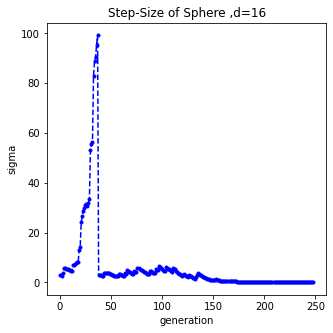

In [125]:
call_cma(domain, objective_function, D=16)

fitness is good enough
y= [1.7231573e-10-2.11299546e-22j] , g= 430
--- execution time: 0.531578540802002 seconds ---


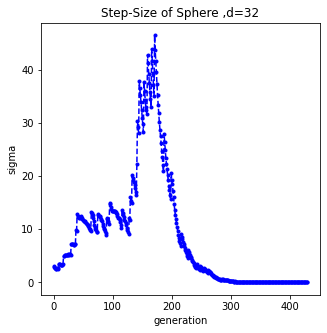

In [161]:
call_cma(domain, objective_function, D=32)

fitness is good enough
y= [3.16276783e-10] , g= 601
--- execution time: 0.31313276290893555 seconds ---


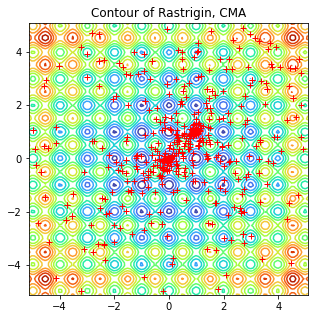

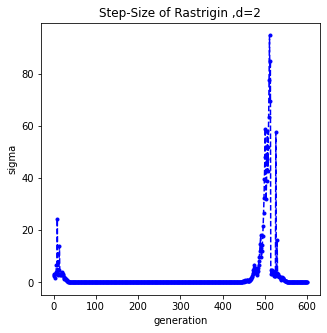

In [162]:
domain=[-5.12, 5.12]
objective_function=Rastrigin

call_cma(domain, objective_function, D=2)

fitness is good enough
y= [1.83604243e-10] , g= 1574
--- execution time: 0.5112650394439697 seconds ---


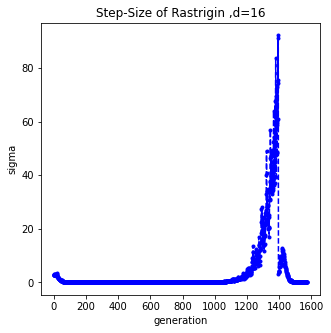

In [166]:
call_cma(domain, objective_function, D=16)

fitness is good enough
y= [2.18506102e-10] , g= 826
--- execution time: 30.466512203216553 seconds ---


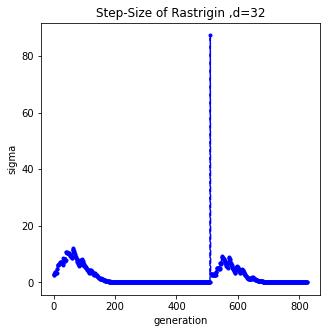

In [168]:
call_cma(domain, objective_function, D=32)

fitness is good enough
y= [1.65879754e-10] , g= 658
--- execution time: 0.2832658290863037 seconds ---


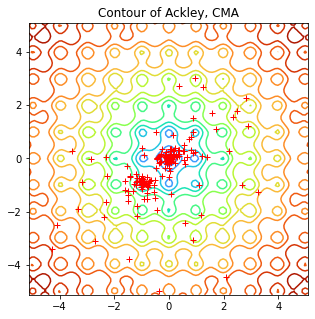

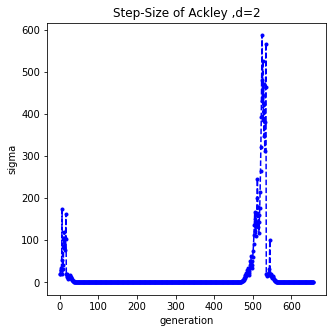

In [169]:
domain=[-32.768, 32.768]
objective_function=Ackley

call_cma(domain, objective_function, D=2)

fitness is good enough
y= [1.03973719e-10] , g= 356
--- execution time: 0.3570432662963867 seconds ---


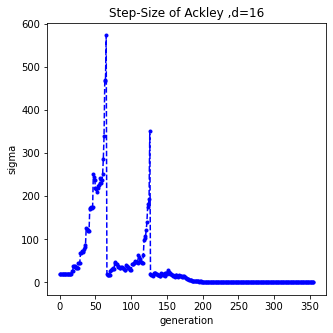

In [177]:
call_cma(domain, objective_function, D=16)

fitness is good enough
y= [1.01099573e-10] , g= 683
--- execution time: 0.6532576084136963 seconds ---


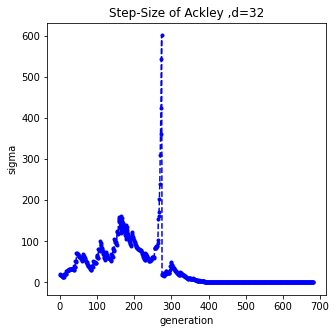

In [200]:
call_cma(domain, objective_function, D=32)